# Patient trajectory analysis

In this notebook, I'll show you an example of sample representation analysis to infer COVID severity trajectory

First, let's import some packages. You might be unfamiliar with [ehrapy](https://github.com/theislab/ehrapy): a package from Theis lab. It is an extension of `scanpy` for electronic health record (EHR) analysis. Many methods fully overlap (e.g. `scanpy.tl.pca` -> `ehrapy.tl.pca`) but there are a bit more. Think of it as `scanpy` but with a bit more cool features and support for categorical data.

In [1]:
import patient_representation as pr
import ehrapy as ep
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc

Here, I use [COMBAT dataset](https://www.kaggle.com/datasets/shitovvladimir/a-blood-atlas-of-covid-19-combat-preprocessed). It contains PBMC from 140 individuals with various COVID severity. You can find processed dataset, more information about it, and link to the publication on [Kaggle](https://www.kaggle.com/datasets/shitovvladimir/a-blood-atlas-of-covid-19-combat-preprocessed).

In [2]:
adata = sc.read_h5ad("data/combat_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 783704 × 3000
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_HC

In [3]:
sample_key = "scRNASeq_sample_ID"
cell_type_key = "Annotation_major_subset"

The following file contains metadata for donors in COMBAT dataset. It is available on GitHub. We will work with it in ehrapy but note that this is just anndata you are used to in single-cell.

There is a bunch of patient representation methods precalculated. Each of them has distances matrix and UMAP in `obsm`, and donors clustering in `obs`. Think of patient representation as distances between patiens: if a distance is equal to 0, transcriptomics profiles of patients are identical. The bigger the number, the bigger the differences.

In [4]:
meta_adata = ep.io.read_h5ad("data/combat_meta_adata.h5ad")
meta_adata

AnnData object with n_obs × n_vars = 137 × 88
    obs: 'Race', 'Institute', 'Tissue', 'DiseaseClassification', 'Pool_ID', 'Source', 'Ethnicity', 'longitudinal_oxygen_phase', 'sampled_at_max_severity', 'potential_exclude', 'low_cellnumber_exclude', 'oxygen_status_sample', 'diabetes', 'comp_total', 'comp_minimal', 'comp_minimal_hosp_covid', 'comp_minimal_plus_transitional', 'MJ_samples', 'random_vec_leiden', 'composition_leiden', 'pseudobulk_leiden', 'pseudobulk_scanvi_pool_leiden', 'pseudobulk_scanvi_leiden', 'pseudobulk_scpoli_leiden', 'pseudobulk_scvi_pool_leiden', 'pseudobulk_scvi_leiden', 'scpoli_leiden', 'mrvi_leiden', 'wasserstein_scanvi_pool_leiden', 'wasserstein_scanvi_leiden', 'wasserstein_scvi_pool_leiden', 'wasserstein_scvi_leiden', 'pilot_leiden', 'gloscope_combat_JS_GMM_25_leiden', 'gloscope_combat_KL_GMM_25_leiden', 'gloscope_combat_KL_KNN_25_leiden', 'WHO_ordinal_at_sample', 'Outcome'
    uns: 'Institute_colors', 'Pool_ID_colors', 'Source_colors', 'composition_leiden_colo

Here, we'll focus on the [GloScope](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-024-03398-1) representation obtained on [scPoli](https://www.nature.com/articles/s41592-023-02035-2) cell embeddings. Notably, this method doesn't use any information about patients: neither their clinical status nor even cell type annotation of the data. However, as we'll see, it provides extremely good patient representation.

In [5]:
representation = "gloscope_combat_KL_KNN_25"

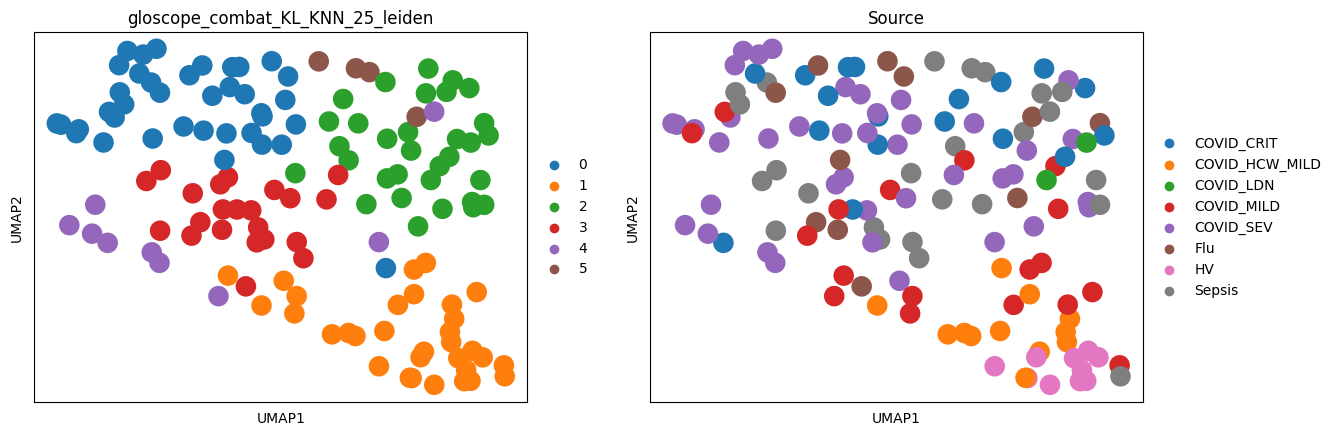

In [6]:
# Set obsm key so that standart umap plotting uses this representation
meta_adata.obsm["umap"] = meta_adata.obsm[f"{representation}_UMAP"]
# Plot UMAP, just like in scanpy. Note that every dot is a donor here!
ep.pl.umap(meta_adata, color=[f"{representation}_leiden", "Source"])

Let's rename some of the columns for a better readability:

In [7]:
meta_adata.obs["Source"] = meta_adata.obs["Source"].map(
    {
        "HV": "Healthy",
        "COVID_MILD": "Mild",
        "COVID_SEV": "Severe",
        "COVID_CRIT": "Critical",
        "COVID_HCW_MILD": "Mild",  # These are healthcare workers with mild disease
        "COVID_LDN": "Critical",
        "Sepsis": "Sepsis",
        "Flu": "Flu",
    }
)

In [8]:
source_palette = {
    "Healthy": "#1f77b4",  # HV
    "Mild": "#ff9999",  # COVID_MILD
    "Severe": "#ff4c4c",  # COVID_SEV
    "Critical": sns.color_palette("Reds")[-1],  # COVID_CRIT
    # "Other": "darkgrey",
    "Sepsis": "#8c564b",  # Sepsis
    "Flu": "#ff7f0e",  # Flu
}

In [9]:
no_box = {
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": False,
    "axes.spines.bottom": False,
    "xtick.bottom": False,
    "xtick.labelbottom": False,
    "ytick.left": False,
    "ytick.labelleft": False,
}
plot_params = {"figure.figsize": (5, 5), "figure.dpi": 150, "axes.grid": False}
plot_params.update(no_box)

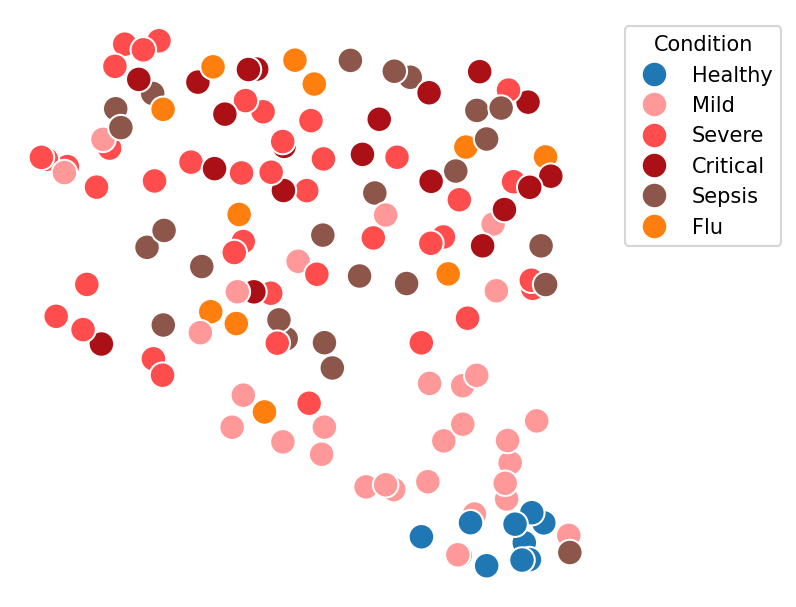

In [10]:
with plt.rc_context(plot_params):
    sns.scatterplot(
        x=meta_adata.obsm[f"{representation}_UMAP"][:, 0],
        y=meta_adata.obsm[f"{representation}_UMAP"][:, 1],
        hue=meta_adata.obs["Source"],
        palette=source_palette,
        hue_order=source_palette.keys(),
        s=150,
    )
    plt.legend(loc=(1.05, 0.6), title="Condition")

Note how all the healthy donors group together, and the severity gradient to the top. This is remarkable because sample representation methods knows nothing about donors condition and only evaluates how similar their transcriptomics profiles are. There are also some mild and even a septic patient grouping together with healthy. Are those errors of the method or misannotations?

With ehrapy, we can apply some single-cell methods to our data. For example, having a sample representation, we can discover trajectories in it via diffusion pseudotime. For this, we need to set the start of trajectory. Let's take a look at the lowest patient on the UMAP:

In [11]:
control_donor_idx = meta_adata.obsm[f"{representation}_UMAP"][:, 1].argmin()
control_donor = meta_adata.obs_names[control_donor_idx]
meta_adata.obs.loc[control_donor, "Source"]

'Healthy'

Some variables are stored in `meta_adata.X` rather then in `.obs`. You can check which ones by running `meta_adata.var_names`

In [12]:
meta_adata[control_donor, ["Age", "Sex", "BMI", "Smoking"]].X

ArrayView([[74.,  0.,  5.,  0.]], dtype=float32)

Ok, so we have a 74-years old non-smoking individual. Perhaps, somebody younger would be a better control but this should be a good start. Also, the dataset has a bit of bias for the older population:

<AxesSubplot: ylabel='Count'>

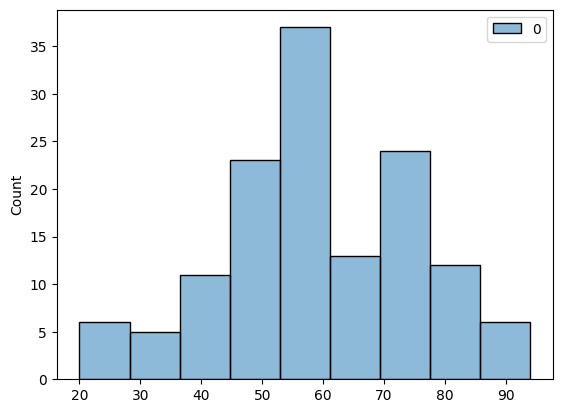

In [13]:
sns.histplot(meta_adata[:, "Age"].X)

Let's set this individual as a root for pseudotime, and run the diffusion:

In [14]:
meta_adata.uns["iroot"] = np.flatnonzero(meta_adata.obs_names == control_donor)[0]
ep.tl.dpt(meta_adata, neighbors_key=f"{representation}_neighbors")

We now have a contunuous score from 0 (for the root we set) to 1 (for a most dissimilar sample), putting every donor on a continuous trajectory

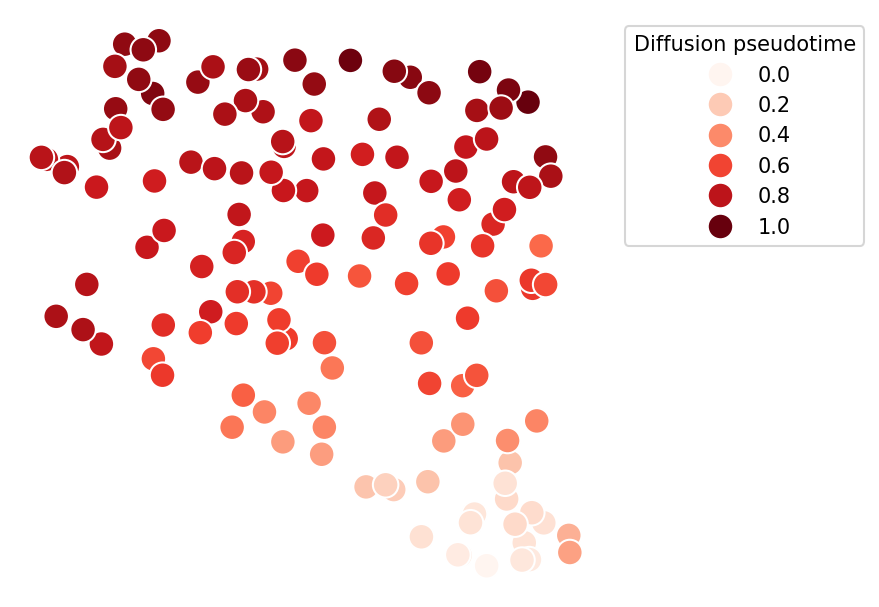

In [15]:
with plt.rc_context(plot_params):
    sns.scatterplot(
        x=meta_adata.obsm[f"{representation}_UMAP"][:, 0],
        y=meta_adata.obsm[f"{representation}_UMAP"][:, 1],
        hue=meta_adata.obs["dpt_pseudotime"],
        s=150,
        palette="Reds",
    )
    plt.legend(loc=(1.05, 0.6), title="Diffusion pseudotime")

But is this score meaningful? Let's take a look at how it corresponds to the severity:

Text(0, 0.5, '')

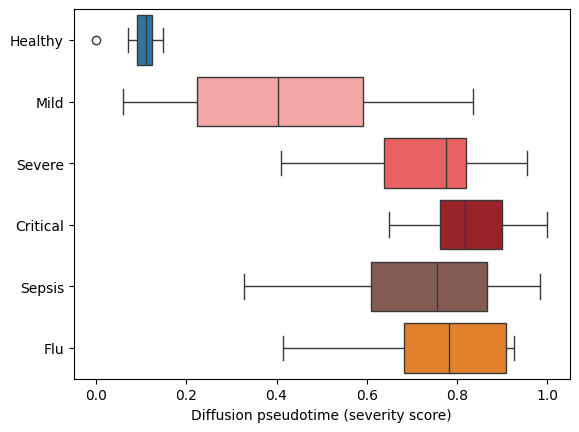

In [16]:
sns.boxplot(
    x=meta_adata.obs["dpt_pseudotime"],
    y=meta_adata.obs["Source"],
    palette=source_palette,
    order=[key for key in source_palette.keys() if key in meta_adata.obs["Source"].unique()],
)
plt.xlabel("Diffusion pseudotime (severity score)")
plt.ylabel("")

We see that higher severity patients have a higher pseudotime score! But instead of a coarse clinical resolution, we now have a continuous trajectory. We now can take a look at what correlates with this trajectory. It could be:
- Cell type proportions
- Gene expression

For the former, let's calculate cell type composition for each patient. You can easily do it with `patient_representation` package:

In [17]:
cell_type_corrs = pr.tl.correlate_composition(
    meta_adata=meta_adata,
    expression_adata=adata,
    sample_key=sample_key,
    cell_type_key=cell_type_key,
    target="dpt_pseudotime",
)
cell_type_corrs

0 samples removed: 
0 cell types removed: 


,correlation,p_value,p_value_adj,-log_p_value_adj
PB,0.451239,3.131071e-08,5.322821e-07,14.446092
PLT,0.435727,1.028075e-07,5.825759e-07,14.355806
DC,-0.438586,8.293978e-08,5.825759e-07,14.355806
cMono,0.430760,1.485891e-07,6.315037e-07,14.275162
MAIT,-0.422133,2.778327e-07,9.446311e-07,13.872471
HSC,0.339631,4.902797e-05,1.389126e-04,8.881666
NK,-0.333424,6.850823e-05,1.663771e-04,8.701253
iNKT,-0.298163,4.019908e-04,8.542304e-04,7.065310
CD8,-0.291742,5.421241e-04,1.024012e-03,6.884027
DN,-0.238690,4.970933e-03,7.682351e-03,4.868830


Note that in the [COMBAT paper](https://pubmed.ncbi.nlm.nih.gov/35216673/), authors define the following hallmarks of COVID severity:
- Increased level of plasmoblasts (PB), classical monocytes (cMono), platelets (PLT), hemapoetic stem cells (HSCs)
- Decreased levels of dendritic cells (DC), NK cells, T

This is precicely what we see! Interestingly, But for MAIT, our results contradict the paper: they suggest that this cell type should be positively correlated with severity.

But are there particular cell states or gene progrmas that explain COVID? To find them, let's take a look at the average gene expression within each cell type, and correlate it with our severity score

In [18]:
expression_dpt_correlation_df = pr.tl.correlate_cell_type_expression(
    meta_adata=meta_adata,
    expression_adata=adata,
    sample_key=sample_key,
    cell_type_key=cell_type_key,
    target="dpt_pseudotime",
    layer="X",
    min_sample_size=500,
)

3 samples removed: U00504-Ua005E-PBUa, G05092-Ja005E-PBCa, S00030-Ja003E-PBCa
0 cell types removed: 


In [19]:
expression_dpt_correlation_df

,cell_type,gene_name,correlation,p_value,n_observations,p_value_adj,-log_p_value_adj
9151,cMono,S100A8,0.884355,1.671033e-46,137,8.143443e-42,94.611361
11814,cMono,NKG7,0.876631,1.003818e-44,137,2.445953e-40,91.208969
11705,cMono,MCEMP1,0.868571,5.428303e-43,137,8.817916e-39,87.624033
11941,cMono,LGALS1,0.867283,1.002285e-42,137,1.221108e-38,87.298475
10647,cMono,MS4A4A,0.863694,5.352660e-42,137,5.217023e-38,85.846307
...,...,...,...,...,...,...,...
50296,Mast,SNX22,-0.056274,7.200248e-01,43,1.000000e+00,-0.000000
50897,Mast,IGLV2-18,-0.056294,7.199313e-01,43,1.000000e+00,-0.000000
49900,Mast,RACGAP1,-0.058429,7.097652e-01,43,1.000000e+00,-0.000000
50441,Mast,CYB5D2,-0.058816,7.079269e-01,43,1.000000e+00,-0.000000


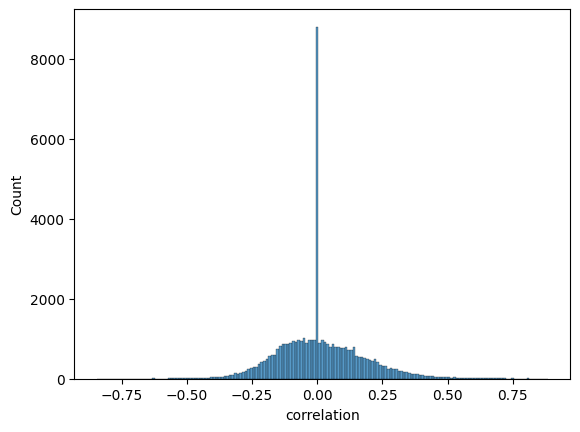

In [20]:
sns.histplot(expression_dpt_correlation_df["correlation"]);

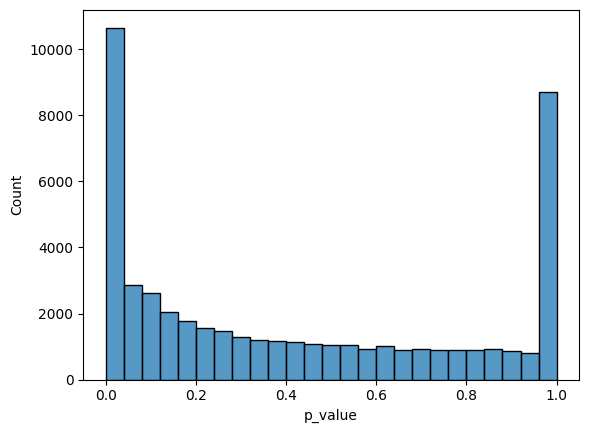

In [21]:
sns.histplot(expression_dpt_correlation_df["p_value"]);

The p-values distribution above is not uniform, and has a peak around 0, which suggests that there are some genes with statistically significant correlation. Let's take a look at top correlated genes:

In [22]:
expression_dpt_correlation_df.head(50)

,cell_type,gene_name,correlation,p_value,n_observations,p_value_adj,-log_p_value_adj
9151,cMono,S100A8,0.884355,1.671033e-46,137,8.143443e-42,94.611361
11814,cMono,NKG7,0.876631,1.003818e-44,137,2.445953e-40,91.208969
11705,cMono,MCEMP1,0.868571,5.428303e-43,137,8.817916e-39,87.624033
11941,cMono,LGALS1,0.867283,1.002285e-42,137,1.221108e-38,87.298475
10647,cMono,MS4A4A,0.863694,5.352660e-42,137,5.217023e-38,85.846307
9763,cMono,SLC39A8,0.849828,2.272493e-39,137,1.845757e-35,79.977589
9149,cMono,S100A9,0.848246,4.359564e-39,137,3.035066e-35,79.480245
10017,cMono,HLA-DMB,-0.844671,1.849540e-38,137,1.126670e-34,78.168627
10529,cMono,ALDH1A1,-0.844298,2.146335e-38,137,1.162193e-34,78.137585
9582,cMono,ACOX2,0.816921,4.524036e-34,137,2.204698e-30,68.286962


This list is largely dominated by classical monocytes. Look at the top correlated gene! In the paper, authors write that S100A8 is a known biomarker, and its expression in cMonocytes correlates with severity. Other markers they mention (`S100A9`, `S100A12`, negative marker `HLA-DRA`) can also be found in the table. Thus, our severity score works

Let's visualize the correlated genes in classical monocytes as they by far dominate in the table. Average expression per sample is now stored in `meta_adata.obsm` in keys `{cell_type}_pseudobulk`. This is controlled by the argument `keep_pseudobulks_in_data` in `pr.tl.correlate_cell_type_expression`, set it to `False` if you want to save memory

In [23]:
cmono_expression_df = meta_adata.obsm["cMono_pseudobulk"]
cmono_expression_df

,ISG15,TNFRSF18,TNFRSF4,TAS1R3,PRDM16,SMIM1,ACOT7,TNFRSF9,ENO1,SLC2A5,...,MT-CO1,MT-CO2,MT-CO3,MT-ND6,MT-CYB,AC136616.3,AC136616.2,AC141272.1,AC233755.2,AC233755.1
scRNASeq_sample_ID,,,,,,,,,,,,,,,,,,,,,
S00078-Ja003E-PBCa,0.666305,0.001183,0.001026,0.001029,0.0,0.007825,0.001336,0.002106,1.545473,0.005381,...,4.252630,4.054601,3.459366,0.253607,2.783757,0.0,0.0,0.000000,0.008152,0.024226
G05064-Ja005E-PBCa,0.329458,0.000000,0.001716,0.000000,0.0,0.009752,0.006973,0.003692,1.135410,0.001092,...,3.937209,3.933448,3.238184,0.120764,2.759863,0.0,0.0,0.000000,0.008778,0.001008
N00027-Ja001E-PBGa,0.161210,0.000000,0.001394,0.001120,0.0,0.015552,0.001609,0.001727,1.073689,0.002531,...,4.248434,4.193965,3.502021,0.204099,2.744123,0.0,0.0,0.000000,0.012055,0.003364
N00040-Ja001E-PBGa,0.186256,0.000875,0.000637,0.000000,0.0,0.002057,0.023947,0.004306,2.204022,0.001281,...,4.030371,3.831872,3.575325,0.584262,2.572893,0.0,0.0,0.000219,0.005552,0.018434
S00066-Ja001E-PBCa,0.702043,0.000779,0.000201,0.000792,0.0,0.008773,0.008580,0.004020,1.877900,0.004006,...,4.106230,3.834373,3.595163,0.707436,2.959860,0.0,0.0,0.000255,0.012751,0.018012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G05112-Ja005E-PBCa,2.783315,0.000000,0.002990,0.000703,0.0,0.005321,0.004147,0.005504,1.606236,0.005606,...,3.401807,3.298067,2.567472,0.232005,1.962488,0.0,0.0,0.000000,0.008089,0.004275
S00042-Ja001E-PBCa,0.076010,0.000700,0.000000,0.000000,0.0,0.011200,0.007901,0.000000,1.740187,0.000000,...,4.230716,4.037877,3.988372,0.513297,2.790164,0.0,0.0,0.000000,0.008693,0.024193
S00067-Ja001E-PBCa,0.403914,0.000000,0.002425,0.000000,0.0,0.009077,0.005603,0.001093,1.808923,0.005293,...,4.086512,3.805610,3.605104,0.434191,2.720078,0.0,0.0,0.000000,0.032481,0.014675


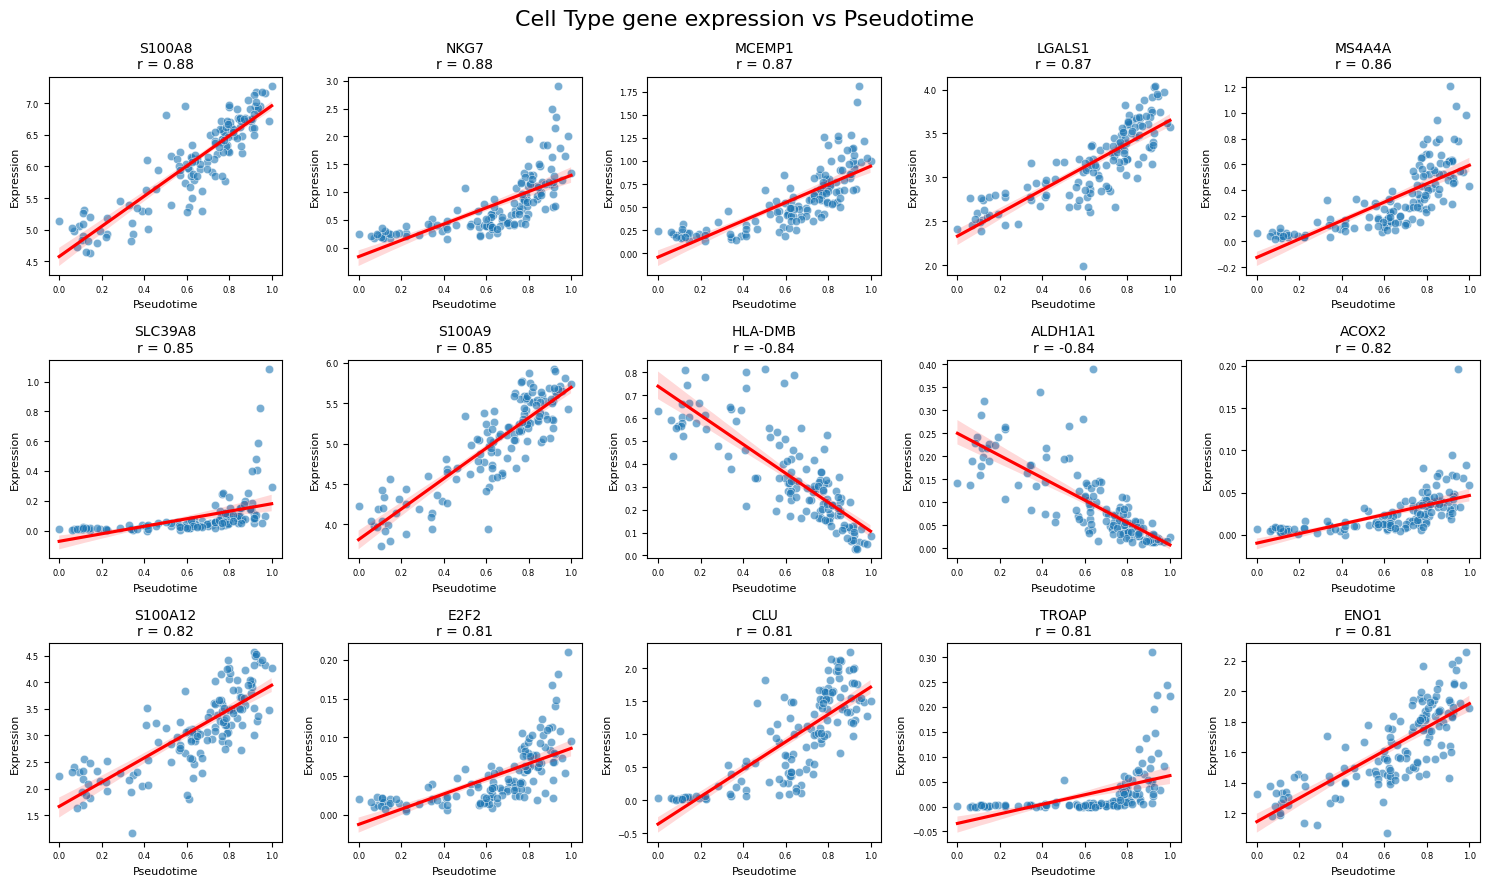

In [24]:
top_genes = expression_dpt_correlation_df.sort_values(["p_value", "correlation"]).head(15)
pseudotime = meta_adata.obs["dpt_pseudotime"]

# Set up the plot
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle("Cell Type gene expression vs Pseudotime", fontsize=16)

# Flatten the axes array for easier iteration
axes_flat = axes.flatten()

# Plot scatterplots for each significant cell type
for i, (_, row) in enumerate(top_genes.iterrows()):
    ax = axes_flat[i]

    gene_expression = cmono_expression_df.loc[pseudotime.index, row["gene_name"]]
    sns.scatterplot(x=pseudotime, y=gene_expression, ax=ax, alpha=0.6)

    # Add regression line
    sns.regplot(x=pseudotime, y=gene_expression, ax=ax, scatter=False, color="red")

    # Set title with correlation value
    correlation = row["correlation"]
    ax.set_title(f"{row['gene_name']}\nr = {correlation:.2f}", fontsize=10)

    # Set labels
    ax.set_xlabel("Pseudotime", fontsize=8)
    ax.set_ylabel("Expression", fontsize=8)

    # Adjust tick label size
    ax.tick_params(axis="both", which="major", labelsize=6)

# Remove any unused subplots
for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

There are certainly non-linear dependencies but S100A8 is a great marker indeed. Let's take a look how it alone explains the severity:

In [25]:
gene_expression = cmono_expression_df.loc[pseudotime.index, "S100A8"]

Text(0, 0.5, '')

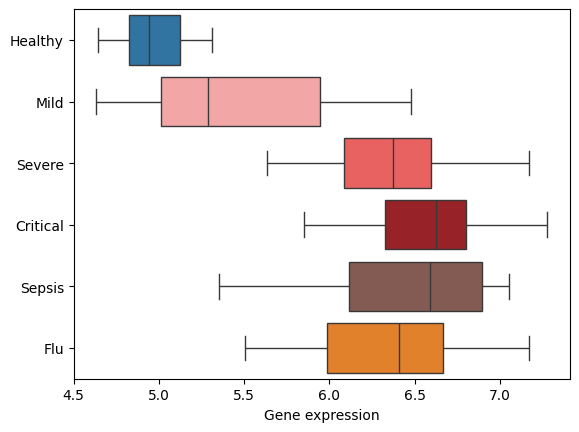

In [26]:
sns.boxplot(
    x=gene_expression.loc[meta_adata.obs_names],
    y=meta_adata.obs["Source"],
    palette=source_palette,
    order=[key for key in source_palette.keys() if key in meta_adata.obs["Source"].unique()],
)
plt.xlabel("Gene expression")
plt.ylabel("")

Well, our score works a bit better but this is definitely a good marker!

We can also visualize results on a volcano plot:

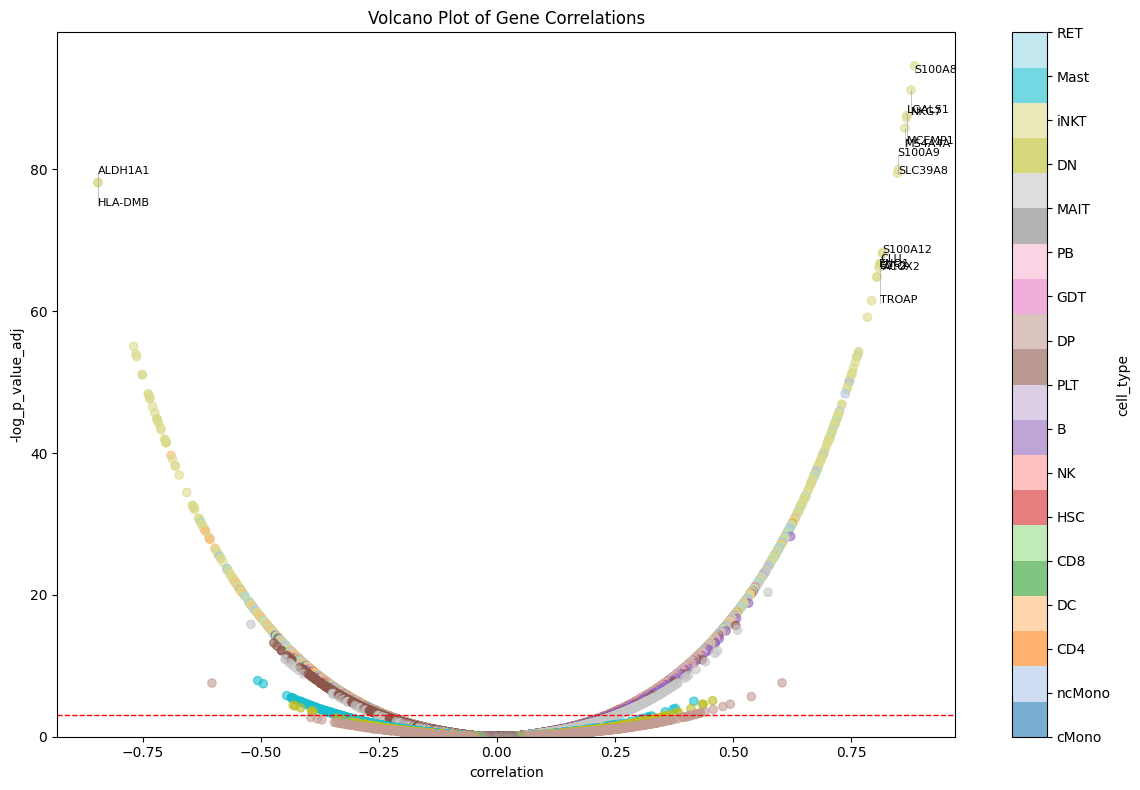

In [27]:
pr.pl.correlation_volcano(expression_dpt_correlation_df, top_n=15);

In summary, we have seen an example of sample-level analysis that allowed us to obtain a continuous severity score, find potential errors in the original clinical annotation, and easily rediscover known markers. Applying such methods to less explored areas might help you discover something new. With `ehrapy` and `patpy` it only requires running a few lines of code